Dans ce notebook, je vais réaliser différentes modélisations grâce à des approches linéaire et non-linéaire afin de prédire la consommation énergétique ainsi que les émissions des gaz à effet de serre des bâtiments non destinés à l’habitation. Pour rappel, le CO2 est l'un des principaux gaz responsable à effet de serre (Le CO2 d’origine humaine est responsable de 65% de l’effet de serre additionnel dû à l’homme)  

Le nettoyage ainsi qu'une analyse exploratoire des données ont été effectués dans le notebook_analyse_exploratoire. 

---------------------------------------------------------------------------------------------------------

In [83]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score

from sklearn.preprocessing import RobustScaler, StandardScaler,OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.linear_model import LinearRegression, Lasso, Ridge,  ElasticNet

from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

from sklearn.dummy import DummyRegressor

from sklearn.tree import DecisionTreeRegressor 

from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor

import xgboost

from xgboost import XGBRegressor

from sklearn.model_selection import validation_curve, learning_curve

from sklearn.base import clone

In [84]:

# fonction plot valeurs predites vs valeurs reelles et la premiere bissectrice
    
def plot_pred_true(y_true, y_pred, color=None, title=None):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred, color=color, alpha=.6)
    X_plot = [y_true.min(), y_true.max()]
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réelles", fontsize=20)
    plt.ylabel("Valeurs prédites", fontsize=20)
    plt.title("Valeurs prédites VS valeurs réelles | Variable {}".format(title), 
              fontsize=20)
  

# fonction qui calcule le pourcentage de mean absolute error MAPE : Mean aboslute percentage error

def mean_absolute_percentage_error(y_true, y_pred): 
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# fonction plot les courbes d'apprentissage d'entrainement et de validation

def plot_learning_curves(model, X_train, X_test, y_train, y_test):
   
    train_errors=[]
    val_errors=[]

    for i in range(1,len(X_train), 10):
        model.fit(X_train[:i],y_train[:i])
        train_preds=model.predict(X_train[:i])
        val_preds=model.predict(X_test)
        train_errors.append(mean_squared_error(train_preds,y_train[:i]))
        val_errors.append(mean_squared_error(val_preds,y_test))
    plt.plot(range(1,len(X_train), 10),np.sqrt(train_errors),label='Training error')
    plt.plot(range(1,len(X_train), 10),np.sqrt(val_errors),label='Validation error')

    plt.title('Learning Curves', fontsize=20)    
    plt.xlabel('Train set size', fontsize=18)
    plt.ylabel('RMSE',fontsize=18)
    plt.legend()          

# Importation des données

In [85]:
df_ml = pd.read_csv("df_final.csv")

In [86]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            1036 non-null   object 
 1   PrimaryPropertyType     1036 non-null   object 
 2   CouncilDistrictCode     1036 non-null   int64  
 3   Neighborhood            1036 non-null   object 
 4   NumberofBuildings       1036 non-null   float64
 5   NumberofFloors          1036 non-null   float64
 6   LargestPropertyUseType  1036 non-null   object 
 7   Latitude                1036 non-null   float64
 8   Longitude               1036 non-null   float64
 9   PropertyGFATotal        1036 non-null   float64
 10  PropertyGFAParking      1036 non-null   float64
 11  ENERGYSTARScore         1036 non-null   float64
 12  SiteEnergyUse(kBtu)     1036 non-null   float64
 13  TotalGHGEmissions       1036 non-null   float64
 14  BuildingAge             1036 non-null   

Lors de l'enregistrement du fichier, la variable 'CouncilDistrictCode' que j'ai converti en objet comme c'est plutot une variable catégorielle s'est enregistré comme int64. reconversion en str

In [87]:
# Convertir variable 'CouncilDistrictCode' en variable catégorielle
df_ml["CouncilDistrictCode"] = df_ml["CouncilDistrictCode"].apply(str)

In [88]:
df_ml.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'NumberofBuildings', 'NumberofFloors',
       'LargestPropertyUseType', 'Latitude', 'Longitude', 'PropertyGFATotal',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'BuildingAge', 'Nbusagetot'],
      dtype='object')

# Préparation des données

### Séparation des variables catégorielles et numériques

In [89]:
num = list(df_ml.select_dtypes(include=['int64','float64']).columns)
cat = list(df_ml.select_dtypes(exclude=['int64','float64']).columns) 

print(f"num =", num)
print(f"cat =", cat)

num = ['NumberofBuildings', 'NumberofFloors', 'Latitude', 'Longitude', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'BuildingAge', 'Nbusagetot']
cat = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType']


-----------------------------------------------------------------------------------------------------
Comme expliqué dans le premier notebook, les variables catégorielles 'BuildingType' et 'LargestPropertyUseType' seront mis de coté en premier temps. 'BuildingType': répartition largement désequilibrée de ces 4 catégories.  'LargestPropertyUseType' est une large extension de la variable  'PrimaryPropertyType'

In [90]:
df_ml.drop(['BuildingType', 'LargestPropertyUseType'], axis=1, inplace=True)

In [91]:
num = list(df_ml.select_dtypes(include=['int64','float64']).columns)
cat = list(df_ml.select_dtypes(exclude=['int64','float64']).columns) 

print(f"num =", num)
print(f"cat =", cat)

num = ['NumberofBuildings', 'NumberofFloors', 'Latitude', 'Longitude', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'BuildingAge', 'Nbusagetot']
cat = ['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood']


## Séparation X et y (variables à prédire)

In [92]:
y = df_ml.copy()[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]
X = df_ml.copy().drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)

In [93]:
num=['NumberofBuildings',  'NumberofFloors', 'Latitude', 'Longitude', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'BuildingAge', 'Nbusagetot']


In [94]:
# diviser le dataset en partie entraintement et une partie test pour les predictions

X_train, X_test, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=0)


## Encodage &  Standarisation 


###  Encodage des variables catégorielles

Comme la plupart des algorithmes d’apprentissage ne traitent que des valeurs numériques en entrée, on va transformer les variables catégorielles en variables numériques afin de pouvoir les exploiter. Pour les encoder, je vais utiliser onehotencoder (ohe) qui permet un encodage simple des valeurs catégorielles. Ohe prend une variable catégorielle X et génère une nouvelle variable booléenne (0 ou 1) pour chaque valeur de la catégorie sous la forme X_value, ce qui peut augmenter considérablement le nombre de variables. 

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore' )

X_train_cat = ohe.fit_transform(X_train[cat])
X_test_cat = ohe.transform(X_test[cat])

# df des variables encodées
ohe_train_df =  pd.DataFrame(X_train_cat, columns=ohe.get_feature_names(cat))
ohe_test_df =  pd.DataFrame(X_test_cat, columns=ohe.get_feature_names(cat))
ohe_train_df

### Standarisation (normalisation et centrage)


#### Distribution des variables avant standarisation

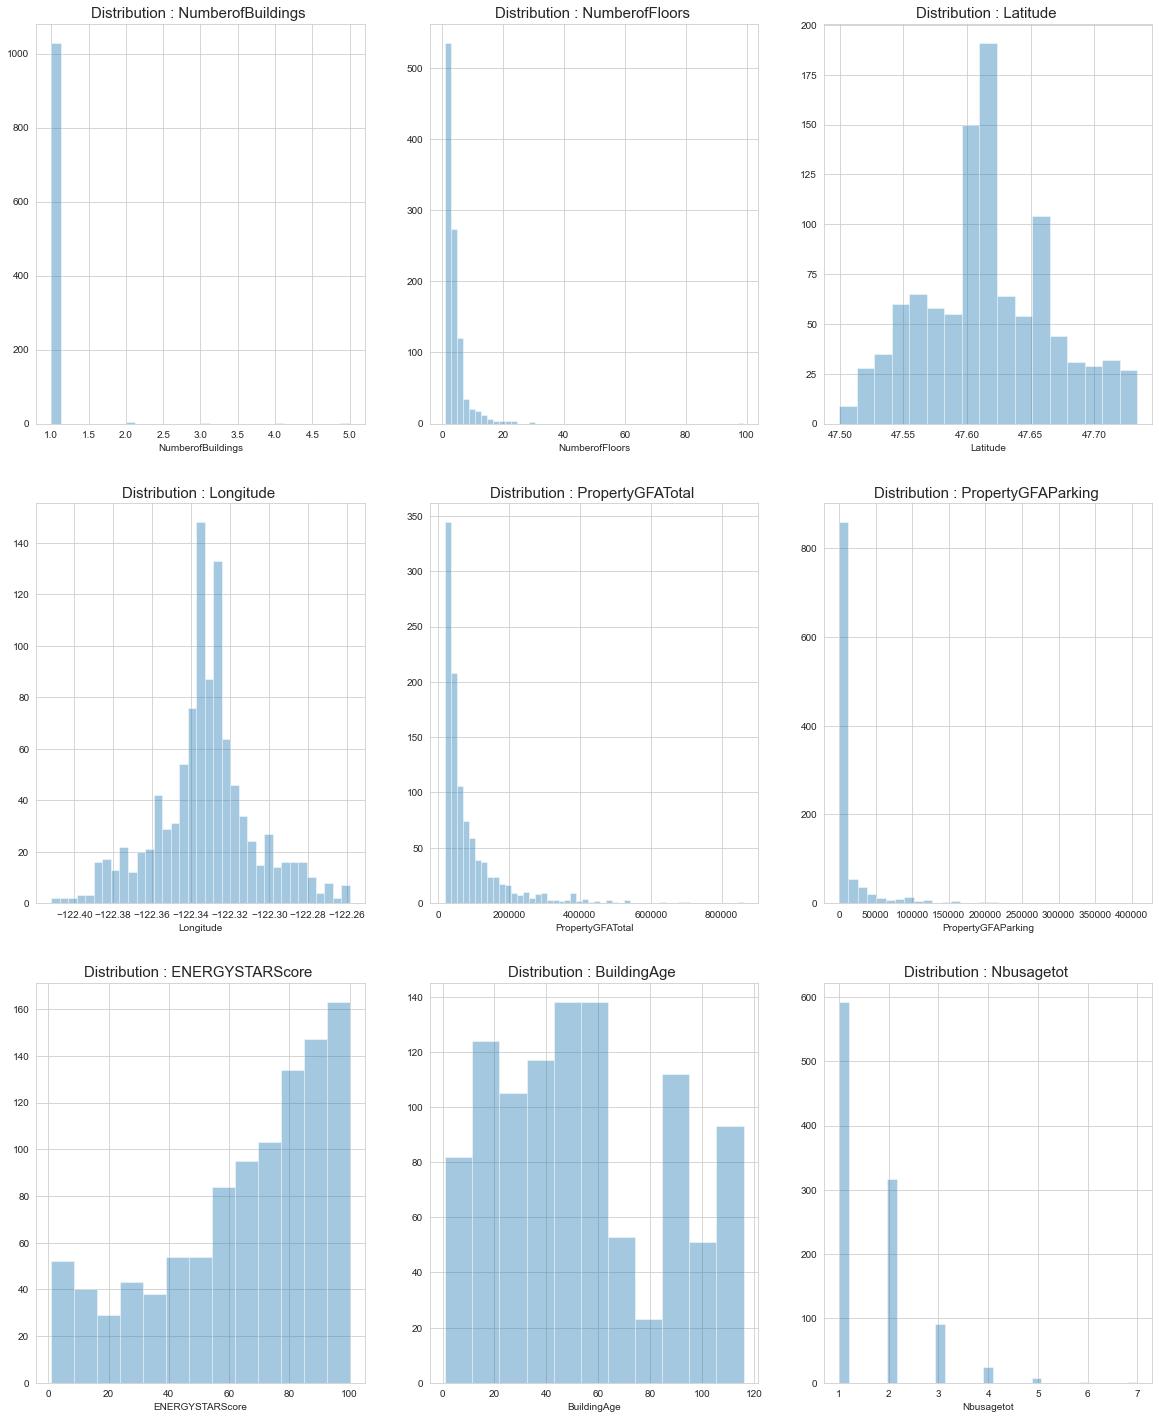

In [96]:
# distribution avant standarisation     
sns.set_style("whitegrid")
fig = plt.figure(figsize=(20,25))

sub = 0
for i in range(len(num)):
    fig.add_subplot(3,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height
    
    colonne = num[i]
    ax = sns.distplot(df_ml[colonne], kde = False)
    ax.set_title(f"Distribution : {colonne} ", fontsize=15)
    sub += 1    
   
plt.savefig('distribution_var_num_avt_std', dpi=200, bbox_inches='tight') 

-------------------------------------------------------------------------------
Les données numériques doivent être standardisées avant de les utiliser dans les modèles de prédiction. J'utiliserais RobustScaler qui est moins sensible aux outliers comme il centre les valeurs par rapport au médiane (J'ai testé  StandardScaler et MinMax qui n'avaient pas d'influence sur les performances des modèles) 
    
-------------------------------------------------------------------------------  

In [97]:
# Standarisation : normalisation et centrage des données numériques 

rbst_scale = RobustScaler()
X_train_num = rbst_scale.fit_transform(X_train[num])
X_test_num = rbst_scale.transform(X_test[num])

# df après standarisation
rbs_train_df = pd.DataFrame(X_train_num, columns=num)
rbs_test_df = pd.DataFrame(X_test_num, columns=num)
rbs_test_df

,NumberofBuildings,NumberofFloors,Latitude,Longitude,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,BuildingAge,Nbusagetot
0,0.0,-0.666667,-1.317964,0.538418,-0.325257,0.0,-0.571429,-0.267241,0.0
1,0.0,-0.666667,-0.649501,-0.849298,0.304662,0.0,-1.033435,0.215517,0.0
2,0.0,-0.666667,1.197939,1.105803,-0.213350,0.0,0.510638,0.094828,0.0
3,0.0,-0.666667,1.560082,1.158414,-0.132940,0.0,0.000000,0.181034,0.0
4,0.0,0.666667,0.100542,-0.558702,0.826700,29409.0,-1.009119,-0.232759,0.0
...,...,...,...,...,...,...,...,...,...
203,0.0,-0.333333,1.015708,-0.952484,-0.438846,0.0,-0.109422,0.750000,0.0
204,0.0,0.000000,0.037852,-0.724946,-0.445418,0.0,-0.206687,0.698276,0.0
205,0.0,-0.666667,0.691062,-1.394331,-0.342170,0.0,-0.145897,-0.474138,2.0
206,0.0,-0.333333,-1.310827,2.816001,-0.368978,0.0,-1.483283,-0.767241,0.0


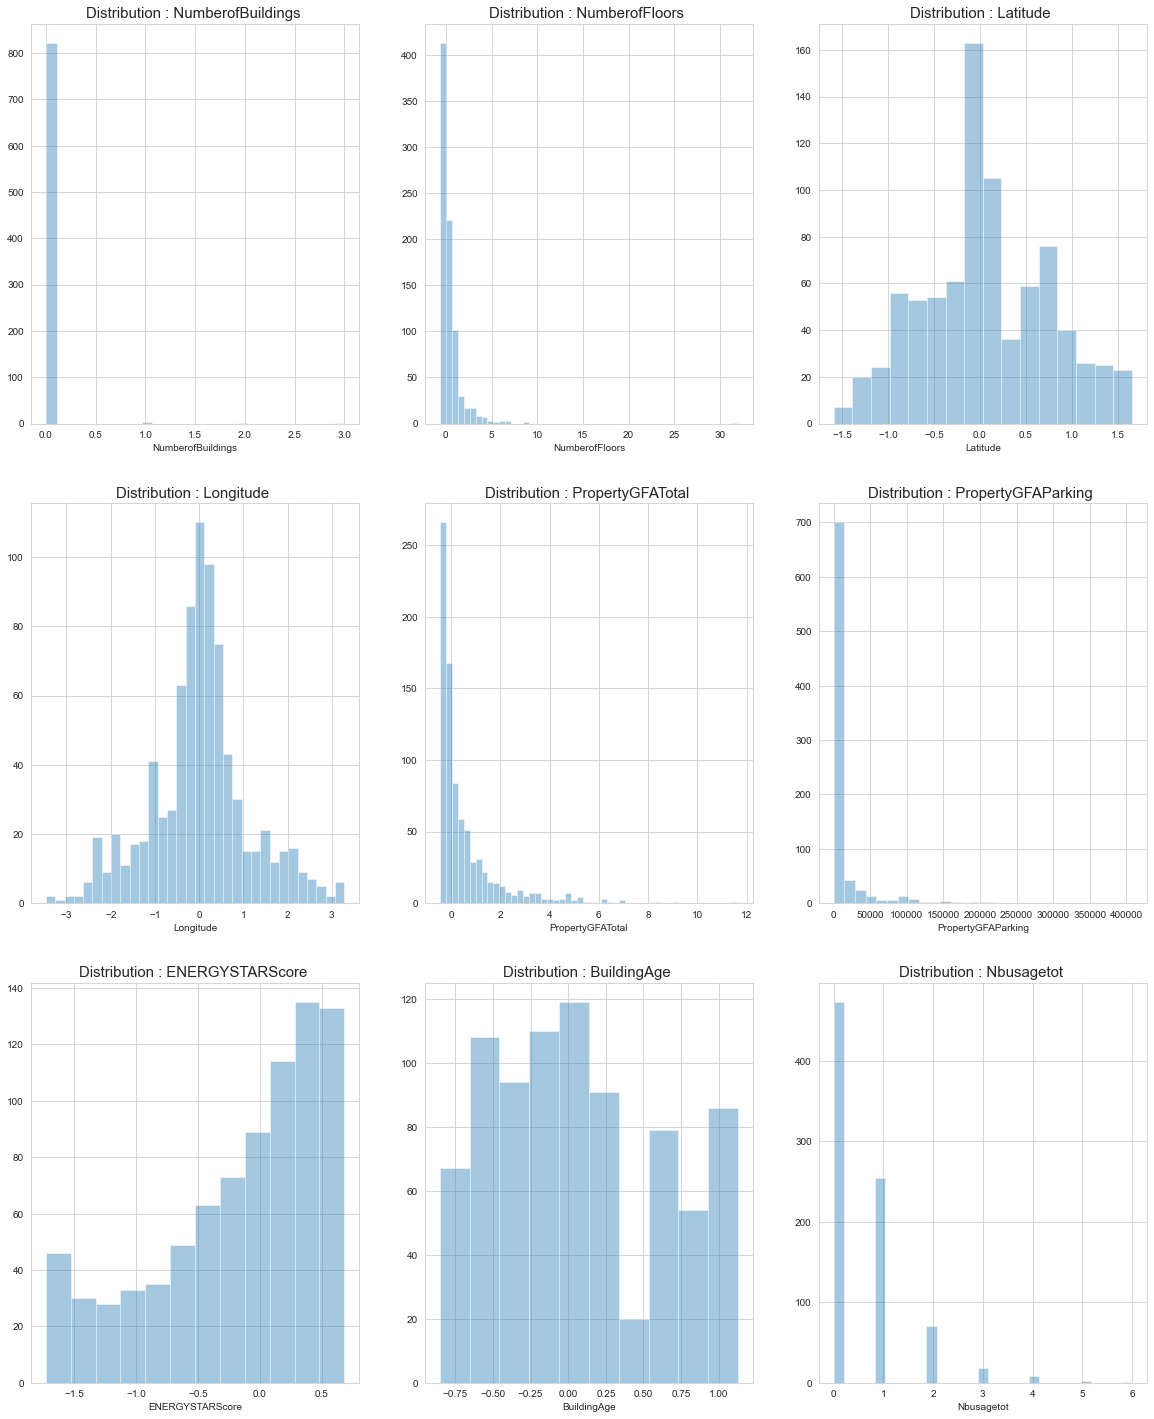

In [98]:
# distribution après standarisation    

sns.set_style("whitegrid")
fig = plt.figure(figsize=(20,25))

sub = 0
for i in range(len(num)):
    fig.add_subplot(3,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height
    
    colonne = num[i]
    ax = sns.distplot(rbs_train_df[colonne], kde=False)
    ax.set_title(f"Distribution : {colonne} ", fontsize=15)
    sub += 1 
    
plt.savefig('distribution_var_num_after_rbs', dpi=200, bbox_inches='tight')       

Certaines variables ont pour médiane zero donc robustscaler ne les change pas

### Concaténation des dataframes des variables encodées et standarisées

In [99]:
X_train_r = pd.concat([rbs_train_df, ohe_train_df], axis = 1)
X_test_r = pd.concat([rbs_test_df, ohe_test_df], axis=1)

# Modélisation

Dans cette partie, je vais tester plusieurs modèles linéaires et non linéaires. Pour évaluer les modèles, je compare deux principales métriques  : la RMSE et la MAE.

#### Erreurs métriques

**RMSE** : L’erreur quadratique moyenne. c'est la racine de la moyenne des carrés des écarts entre les prévisions du modèle et les observations. Elle est donnée par : 

<div style="width:100%;text-align: center;">
<img align=middle src="https://miro.medium.com/max/966/1*lqDsPkfXPGen32Uem1PTNg.png" width="250"/>
   

**Mean Absolute Error** : La moyenne arithmétique des valeurs absolues des écarts. Elle représente la moyenne de la différence absolue entre prévisions du modèle et observations. Elle est donnée par : 


<div style="width:100%;text-align: center;">
<img align=middle src="https://miro.medium.com/max/630/1*OVlFLnMwHDx08PHzqlBDag.gif"width="250"/>
    
Ces deux erreurs sont donc à minimiser. La RMSE est plus sensible que la MAE aux valeurs s'écartant de la normale, ce qui permet de mieux traiter les écarts importants. Le RMSE sera toujours supérieur ou égal au MAE ; plus la différence entre elles est grande, plus la variance des erreurs individuelles dans l'échantillon est grande.    
    
Pour faciliter la compréhension des erreurs, je calcule aussi la MAPE :    
    
**MAPE** renvoie l'erreur MAE sous forme de pourcentage, ce qui facilite la compréhension de la « qualité » de la valeur d'erreur: : 
    
<div style="width:100%;text-align: center;">
<img align=middle src="https://i.imgur.com/YYMpqUY.jpg"width="300"/>     
    
 
J'utiliserais une autre métrique en complément pour avoir une idée plus parlante de la qualité d'un modèle, il s'agit du coefficient de détermination qui s'exprime de la manière suivante :

    
 <div style="width:100%;text-align: center;">
<img align=middle src="https://miro.medium.com/max/548/1*X0_3mtDXwuhd3dl88xR4yA.png" width="300"/>
    
R² varie entre -1 et 1. Plus il est proche de 1 et plus les valeurs prédites et réelles sont corrélés

### Test rapide des différents modèles et comparaison avec un baseline naive dummy regressor

D'abord sans cross validation ni optimisation des hyperparamètres. Je commence par un simple dummyregressor comme un modèle naive de baseline pour comparaison. 

In [100]:
results = []

## DummyRegressor :

In [101]:
df_ypred = pd.DataFrame(columns = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

mod = 'dummy'

dumy_mean = DummyRegressor(strategy = 'mean')

for col in y.columns:
    
    start_time = time.time()
    
    dumy_mean.fit(X_train, y_train_all[col])   
    y_pred = dumy_mean.predict(X_test)
    
    score_entrainement = dumy_mean.score(X_train,y_train_all[col])
    score_prédiction =  dumy_mean.score(X_test, y_test_all[col])
    
    RMSE = mean_absolute_error(y_test_all[col], y_pred)
    MAE = np.sqrt(mean_squared_error(y_test_all[col], y_pred))
    R2 =  r2_score(y_test_all[col], y_pred)
    
    print("")
    print(f"Méthode: DummyMean {col}")
    print('-------------------------------------------------------------------------')
    print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
    print("score_entrainement ", score_entrainement ) 
    print("score_prédiction", score_prédiction)
    
    print("RMSE = ", RMSE)
    print("MAE = ", MAE)
    print("R2=", R2)
    print('-------------------------------------------------------------------------')
    
    results.append([mod, col, score_entrainement, score_prédiction, MAE, RMSE,  R2, (time.time() - start_time)])
    
    df_ypred[col] = y_pred


Méthode: DummyMean SiteEnergyUse(kBtu)
-------------------------------------------------------------------------
Temps d'execution de l'agorithme : 0.003 s.
score_entrainement  0.0
score_prédiction -0.001694707829150044
RMSE =  3479009.111457365
MAE =  4504842.103585513
R2= -0.001694707829150044
-------------------------------------------------------------------------

Méthode: DummyMean TotalGHGEmissions
-------------------------------------------------------------------------
Temps d'execution de l'agorithme : 0.002 s.
score_entrainement  0.0
score_prédiction -0.00022578650475879591
RMSE =  71.546826865013
MAE =  98.31319848403314
R2= -0.00022578650475879591
-------------------------------------------------------------------------


In [102]:
algos = {'Dummyregression': DummyRegressor(strategy = 'mean'),
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol = 0.5),
    'ElasticNet' : ElasticNet(),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth = 3),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}
first_results = []
for algo_name, algo in algos.items():
    print('Algorithme: ', algo_name)
    
    for col in y.columns:
        start_time = time.time()
        
        model = algo
          
        model.fit(X_train_r, y_train_all[col])
        y_pred = model.predict(X_test_r)
        
        score_entrainement = model.score(X_train_r, y_train_all[col])
        score_prédiction =  model.score(X_test_r, y_test_all[col])
        
        RMSE = mean_absolute_error(y_test_all[col], y_pred)
        MAE = np.sqrt(mean_squared_error(y_test_all[col], y_pred))
        R2 =  r2_score(y_test_all[col], y_pred)
        
        print('Prédiction de ', col)
        print("score d'entrainement = ", model.score(X_train_r, y_train_all[col]))
        print("score de la prédiction: ",  model.score(X_test_r, y_test_all[col]))
        
        print("MAE = ", MAE)        
        print("RMSE = ", RMSE)
        print("R2=", R2)
        first_results.append([algo_name, col, score_entrainement, score_prédiction, MAE, RMSE,  R2, (time.time() - start_time)])
        
    
    print('-'*100)

Algorithme:  Dummyregression
Prédiction de  SiteEnergyUse(kBtu)
score d'entrainement =  0.0
score de la prédiction:  -0.001694707829150044
MAE =  4504842.103585513
RMSE =  3479009.111457365
R2= -0.001694707829150044
Prédiction de  TotalGHGEmissions
score d'entrainement =  0.0
score de la prédiction:  -0.00022578650475879591
MAE =  98.31319848403314
RMSE =  71.546826865013
R2= -0.00022578650475879591
----------------------------------------------------------------------------------------------------
Algorithme:  LinearRegression
Prédiction de  SiteEnergyUse(kBtu)
score d'entrainement =  0.7839379991939286
score de la prédiction:  0.6931673912607842
MAE =  2493231.699686539
RMSE =  1520642.8006803305
R2= 0.6931673912607842
Prédiction de  TotalGHGEmissions
score d'entrainement =  0.5011092599306357
score de la prédiction:  0.4735648733146983
MAE =  71.3239245933605
RMSE =  45.02604637032394
R2= 0.4735648733146983
----------------------------------------------------------------------------

In [103]:
first_results_engy = []
first_results_CO2 = []
for i in range(0,len(first_results),2):
    first_results_engy.append(first_results[i])
for i in range(1,len(first_results),2):
    first_results_CO2.append(first_results[i])    

df_first_results_engy = pd.DataFrame(first_results_engy, columns = ['model', 'variable_to_predict', 'Score_ent', 'Score_pred', 'MAE', 'RMSE', 'R2', 'execution_time'])
df_first_results_CO2 = pd.DataFrame(first_results_CO2, columns = ['model', 'variable_to_predict','Score_ent', 'Score_pred', 'MAE', 'RMSE', 'R2', 'execution_time'])

display(df_first_results_engy)
display(df_first_results_CO2)

,model,variable_to_predict,Score_ent,Score_pred,MAE,RMSE,R2,execution_time
0,Dummyregression,SiteEnergyUse(kBtu),0.000000,-0.001695,4.504842e+06,3.479009e+06,-0.001695,0.002993
1,LinearRegression,SiteEnergyUse(kBtu),0.783938,0.693167,2.493232e+06,1.520643e+06,0.693167,0.013980
2,Ridge,SiteEnergyUse(kBtu),0.782315,0.691281,2.500882e+06,1.537519e+06,0.691281,0.011967
3,Lasso,SiteEnergyUse(kBtu),0.770141,0.694771,2.486708e+06,1.549443e+06,0.694771,0.008976
4,ElasticNet,SiteEnergyUse(kBtu),0.628991,0.510026,3.150638e+06,2.110574e+06,0.510026,0.010973
5,SVR,SiteEnergyUse(kBtu),-0.163418,-0.125206,4.774499e+06,2.962613e+06,-0.125206,0.235613
6,DecisionTreeRegressor,SiteEnergyUse(kBtu),0.727246,0.522251,3.111084e+06,1.945159e+06,0.522251,0.010543
7,RandomForestRegressor,SiteEnergyUse(kBtu),0.971951,0.747775,2.260509e+06,1.345727e+06,0.747775,0.562004
8,XGBRegressor,SiteEnergyUse(kBtu),0.999603,0.765171,2.181162e+06,1.330016e+06,0.765171,0.163612


,model,variable_to_predict,Score_ent,Score_pred,MAE,RMSE,R2,execution_time
0,Dummyregression,TotalGHGEmissions,0.000000,-0.000226,98.313198,71.546827,-0.000226,0.002992
1,LinearRegression,TotalGHGEmissions,0.501109,0.473565,71.323925,45.026046,0.473565,0.016937
2,Ridge,TotalGHGEmissions,0.496045,0.483959,70.616305,44.629144,0.483959,0.010971
3,Lasso,TotalGHGEmissions,0.427877,0.417229,75.043253,49.288524,0.417229,0.010383
4,ElasticNet,TotalGHGEmissions,0.263719,0.199407,87.956640,59.867233,0.199407,0.009587
5,SVR,TotalGHGEmissions,-0.135213,-0.083397,102.319056,60.855218,-0.083397,0.224242
6,DecisionTreeRegressor,TotalGHGEmissions,0.409571,0.403010,75.953241,51.669240,0.403010,0.010231
7,RandomForestRegressor,TotalGHGEmissions,0.927932,0.545998,66.235666,43.559142,0.545998,0.582104
8,XGBRegressor,TotalGHGEmissions,0.997523,0.566460,64.725777,41.898065,0.566460,0.176925


In [104]:
df_first_results_CO2_ = df_first_results_CO2.drop(df_first_results_CO2.loc[df_first_results_CO2['model']=='SVR'].index)

In [105]:
df_first_results_engy_ = df_first_results_engy.drop(df_first_results_engy.loc[df_first_results_CO2['model']=='SVR'].index)

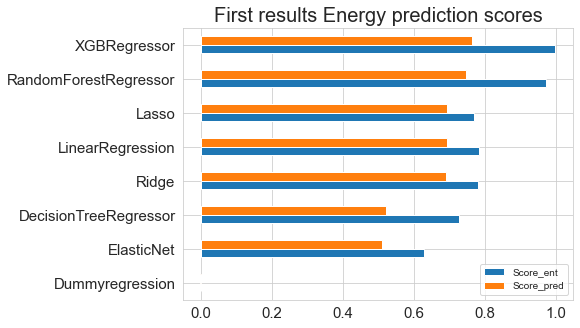

In [106]:
df_first_results_engy_.sort_values(by = 'R2').plot.barh(figsize = (7,5), y = ['Score_ent','Score_pred'], x = 'model', fontsize = 15)
plt.title('First results Energy prediction scores', fontsize = 20)
plt.ylabel('')
plt.savefig('scores first results-reelles-predites_engy', dpi = 200, bbox_inches = 'tight')    

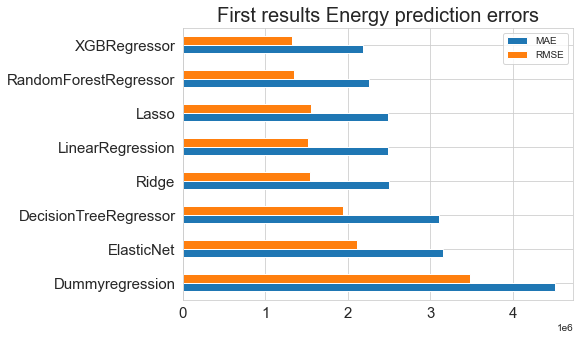

In [107]:
df_first_results_engy_.sort_values(by = 'MAE', ascending = False).plot.barh(y = ['MAE', 'RMSE'], x = 'model', figsize = (7,5), fontsize = 15)
plt.title('First results Energy prediction errors', fontsize = 20)
plt.ylabel('')
plt.savefig('firt results erreurs-reelles-predites_engy', dpi = 200, bbox_inches = 'tight')   

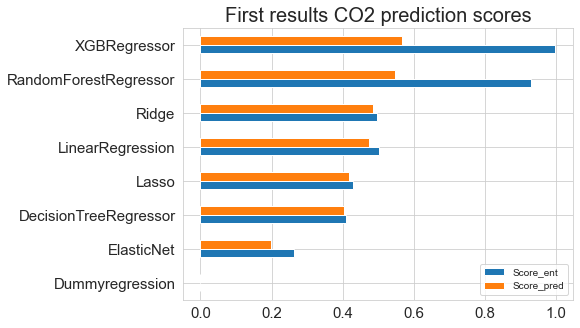

In [108]:
df_first_results_CO2_.sort_values(by = 'R2').plot.barh(figsize = (7,5), y = ['Score_ent','Score_pred'], x = 'model', fontsize = 15)
plt.title('First results CO2 prediction scores', fontsize = 20)
plt.ylabel('')
plt.savefig('scores first results-reelles-predites_gaz', dpi = 200, bbox_inches = 'tight')  

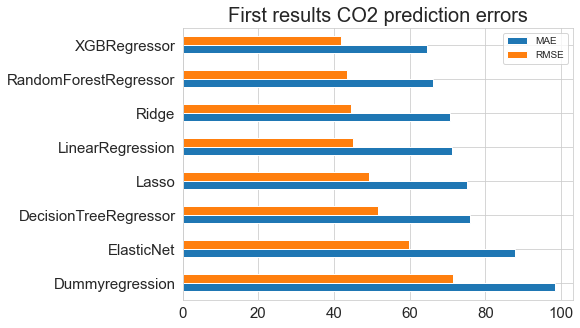

In [109]:
df_first_results_CO2_.sort_values(by = 'MAE', ascending=False).plot.barh(y = ['MAE', 'RMSE'], x = 'model', figsize = (7,5), fontsize = 15)
plt.title('First results CO2 prediction errors', fontsize = 20)
plt.ylabel('')
plt.savefig('first results erreurs-reelles-predites_gaz', dpi = 200, bbox_inches = 'tight')     

Les meilleurs modèles pour le premier test sont :  
    - Le modèle Ridge parmi les modèles linéaires  
    - Les modèles non-linéaires Random Forest Regressor et XGBoost Regressor  


Pour optimiser les résultats, on va chercher les meilleurs hyperparamètres pour chaque modèle moyennant de gridsearch ainsi que de cross validation qui va évaluer chaque combinaison de paramètres sur différente partie du dataset train (X_train)

### Validation croisée

In [110]:
scores_engy = cross_val_score(Ridge(random_state = 0),
                             X_train_r,
                             y_train_all['SiteEnergyUse(kBtu)'],
                             cv = 5,
                             scoring = 'r2', error_score = 'raise')
print('CV Mean: ', np.mean(scores_engy))
print('STD: ', np.std(scores_engy))
print('\n')

CV Mean:  0.7471083278989528
STD:  0.05411939461496592




In [111]:
cross_validate(Ridge(), X_train_r, y_train_all['SiteEnergyUse(kBtu)'], cv = 5, scoring = 'r2', return_train_score = True)

{'fit_time': array([0.00398588, 0.00498557, 0.00498676, 0.00299215, 0.00203466]),
 'score_time': array([0.00299358, 0.002105  , 0.00103927, 0.00099683, 0.00195479]),
 'test_score': array([0.74393981, 0.79496686, 0.78077353, 0.77173099, 0.64413045]),
 'train_score': array([0.78600661, 0.77399013, 0.77529821, 0.77958262, 0.81121064])}

## GridSearch + cross validation

## Ridge

In [112]:
Ridge().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

## Linear Regression Ridge 

In [113]:
n_alphas = 10
alphas = np.logspace(-5,10, n_alphas)
params_rdg = {'alpha':alphas} 

mod = 'Ridge'

model = GridSearchCV(estimator = Ridge(random_state = 0), param_grid = params_rdg, cv = 5,
               scoring = 'r2', refit = 'r2',
               return_train_score = False, n_jobs = -1)
              


for col in y.columns:
        
    start_time = time.time()
    
    model.fit(X_train_r, y_train_all[col])   
    y_pred = model.predict(X_test_r)
    
    score_entrainement = model.score(X_train_r,y_train_all[col])
    score_prédiction =  model.score(X_test_r, y_test_all[col])
    
    RMSE = mean_absolute_error(y_test_all[col], y_pred)
    MAE = np.sqrt(mean_squared_error(y_test_all[col], y_pred))
    R2 =  r2_score(y_test_all[col], y_pred)
        
   
   
    print("")
    print(f'Méthode: {mod} OneHotEncoder RobustScaler {col}')
    print('-------------------------------------------------------------------------')
    print("best params: ", model.best_params_)
    print ("best score : ", model.best_score_)
    
    print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
    print("score_entrainement ", score_entrainement ) 
    print("score_prédiction", score_prédiction)
    
    print("RMSE = ", RMSE)
    print("MAE = ", MAE)
    print("R2=", R2)
    print('-------------------------------------------------------------------------')
    
    results.append([mod, col, score_entrainement, score_prédiction, MAE, RMSE,  R2, (time.time() - start_time)])


Méthode: Ridge OneHotEncoder RobustScaler SiteEnergyUse(kBtu)
-------------------------------------------------------------------------
best params:  {'alpha': 1.0}
best score :  0.7471083278989527
Temps d'execution de l'agorithme : 5.2 s.
score_entrainement  0.7823152175003373
score_prédiction 0.6912814298264736
RMSE =  1537519.2803323998
MAE =  2500882.3459001877
R2= 0.6912814298264736
-------------------------------------------------------------------------

Méthode: Ridge OneHotEncoder RobustScaler TotalGHGEmissions
-------------------------------------------------------------------------
best params:  {'alpha': 1.0}
best score :  0.41086640793955775
Temps d'execution de l'agorithme : 0.18 s.
score_entrainement  0.49604543294003844
score_prédiction 0.4839588044015537
RMSE =  44.62914447658658
MAE =  70.61630486196962
R2= 0.4839588044015537
-------------------------------------------------------------------------


## RandomForestRegressor

In [114]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [115]:
df_ypred = pd.DataFrame(columns = ['SiteEnergyUse(kBtu)','TotalGHGEmissions'])


rfr_grid = {'n_estimators': [100, 300, 500], 'max_depth':[None, 1,5, 10],
                     'min_samples_split': [1, 5, 10], 'min_samples_leaf':[1,3,5]} 




# Call the model 
rfr = RandomForestRegressor(random_state = 0)

mod = 'RandomForestRegressor'

model = GridSearchCV(estimator = rfr, param_grid = rfr_grid, cv = 5,
               scoring = 'r2', refit = 'r2',
               n_jobs = -1   )
              

for col in y.columns:
        
    start_time = time.time()
    
    model.fit(X_train_r, y_train_all[col])   
    y_pred = model.predict(X_test_r)
    
    score_entrainement = model.score(X_train_r, y_train_all[col])
    score_prédiction =  model.score(X_test_r, y_test_all[col])
    
    RMSE = mean_absolute_error(y_test_all[col], y_pred)
    MAE = np.sqrt(mean_squared_error(y_test_all[col], y_pred))
    R2 =  r2_score(y_test_all[col], y_pred)
         
   
    print("")
    print(f'Méthode: {mod} OneHotEncoder RobustScaler {col}')
    print('-------------------------------------------------------------------------')
    print("best params: ", model.best_params_)
    print ("best score : ", model.best_score_)
    
    print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
    print("score_entrainement ", score_entrainement ) 
    print("score_prédiction", score_prédiction)
    
    print("RMSE = ", RMSE)
    print("MAE = ", MAE)
    print("R2=", R2)
    print('-------------------------------------------------------------------------')
    
    results.append([mod, col, score_entrainement, score_prédiction, MAE, RMSE,  R2, (time.time() - start_time)])
    
    df_ypred[col] = y_pred
    


Méthode: RandomForestRegressor OneHotEncoder RobustScaler SiteEnergyUse(kBtu)
-------------------------------------------------------------------------
best params:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
best score :  0.7872037633562985
Temps d'execution de l'agorithme : 1.1e+02 s.
score_entrainement  0.9375868972677537
score_prédiction 0.7459137547918476
RMSE =  1358049.5605133274
MAE =  2268832.6402329276
R2= 0.7459137547918476
-------------------------------------------------------------------------

Méthode: RandomForestRegressor OneHotEncoder RobustScaler TotalGHGEmissions
-------------------------------------------------------------------------
best params:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
best score :  0.47619129588874587
Temps d'execution de l'agorithme : 1.1e+02 s.
score_entrainement  0.824435395527772
score_prédiction 0.5279842874293859
RMSE =  44.34809165593916
MAE = 

# XGBRegressor

In [116]:
print(XGBRegressor().get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [117]:
# XGB

df_ypred = pd.DataFrame(columns = ['SiteEnergyUse(kBtu)','TotalGHGEmissions'])

xgb_grid = {'learning_rate': [0.05, 0.07, 0.08],
             'max_depth': [5, 6, 7],
             #,'min_child_weight': [4, 5],
          'n_estimators':[100, 200, 300]
          #, 'gamma': [0,  1.0, 10]
          }

# Call the model 
xgb = XGBRegressor(random_state = 0)

mod = 'XGBRegressor'

model = GridSearchCV(estimator = xgb, param_grid = xgb_grid, cv = 5,
               scoring = 'r2', refit = 'r2',
               n_jobs = -1)
              

for col in y.columns:
        
    start_time = time.time()
    
    model.fit(X_train_r, y_train_all[col])   
    y_pred = model.predict(X_test_r)
    
    score_entrainement = model.score(X_train_r, y_train_all[col])
    score_prédiction =  model.score(X_test_r, y_test_all[col])
    
    RMSE = mean_absolute_error(y_test_all[col], y_pred)
    MAE = np.sqrt(mean_squared_error(y_test_all[col], y_pred))
    R2 =  r2_score(y_test_all[col], y_pred)
        
   
   
    print("")
    print(f'Méthode: {mod} OneHotEncoder RobustScaler {col}')
    print('-------------------------------------------------------------------------')
    print("best params: ", model.best_params_)
    print ("best score : ", model.best_score_)
    
    print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
    print("score_entrainement ", score_entrainement ) 
    print("score_prédiction", score_prédiction)
    
    print("RMSE = ", RMSE)
    print("MAE = ", MAE)
    print("R2=", R2)
    print('-------------------------------------------------------------------------')
    
    results.append([mod, col, score_entrainement, score_prédiction, MAE, RMSE,  R2, (time.time() - start_time)])
    
    df_ypred[col] = y_pred


Méthode: XGBRegressor OneHotEncoder RobustScaler SiteEnergyUse(kBtu)
-------------------------------------------------------------------------
best params:  {'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 200}
best score :  0.7983719843019463
Temps d'execution de l'agorithme : 2.6e+01 s.
score_entrainement  0.9861627227808365
score_prédiction 0.791210718637375
RMSE =  1226055.5520566106
MAE =  2056676.489230211
R2= 0.791210718637375
-------------------------------------------------------------------------

Méthode: XGBRegressor OneHotEncoder RobustScaler TotalGHGEmissions
-------------------------------------------------------------------------
best params:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
best score :  0.4846954010700565
Temps d'execution de l'agorithme : 2.4e+01 s.
score_entrainement  0.8597833015725023
score_prédiction 0.5480305134088681
RMSE =  42.51957700986129
MAE =  66.08720121709081
R2= 0.5480305134088681
-----------------------------------

### Comparaison des performances des modèles 

In [118]:
results_engy = []
results_CO2 = []
for i in range(0, len(results), 2):
    results_engy.append(results[i])
for i in range(1, len(results), 2):
    results_CO2.append(results[i])    

df_results_engy = pd.DataFrame(results_engy, columns = ['model', 'variable_to_predict','Score_ent', 'Score_pred', 'MAE', 'RMSE', 'R2', 'execution_time'])
df_results_CO2 = pd.DataFrame(results_CO2, columns = ['model', 'variable_to_predict','Score_ent', 'Score_pred', 'MAE', 'RMSE', 'R2', 'execution_time'])

display(df_results_engy)
display(df_results_CO2)

,model,variable_to_predict,Score_ent,Score_pred,MAE,RMSE,R2,execution_time
0,dummy,SiteEnergyUse(kBtu),0.000000,-0.001695,4.504842e+06,3.479009e+06,-0.001695,0.002992
1,Ridge,SiteEnergyUse(kBtu),0.782315,0.691281,2.500882e+06,1.537519e+06,0.691281,5.210788
2,RandomForestRegressor,SiteEnergyUse(kBtu),0.937587,0.745914,2.268833e+06,1.358050e+06,0.745914,114.130410
3,XGBRegressor,SiteEnergyUse(kBtu),0.986163,0.791211,2.056676e+06,1.226056e+06,0.791211,26.376575


,model,variable_to_predict,Score_ent,Score_pred,MAE,RMSE,R2,execution_time
0,dummy,TotalGHGEmissions,0.000000,-0.000226,98.313198,71.546827,-0.000226,0.001995
1,Ridge,TotalGHGEmissions,0.496045,0.483959,70.616305,44.629144,0.483959,0.179520
2,RandomForestRegressor,TotalGHGEmissions,0.824435,0.527984,67.536886,44.348092,0.527984,110.366548
3,XGBRegressor,TotalGHGEmissions,0.859783,0.548031,66.087201,42.519577,0.548031,23.761111


#### Pour la consommation totale d'énergie

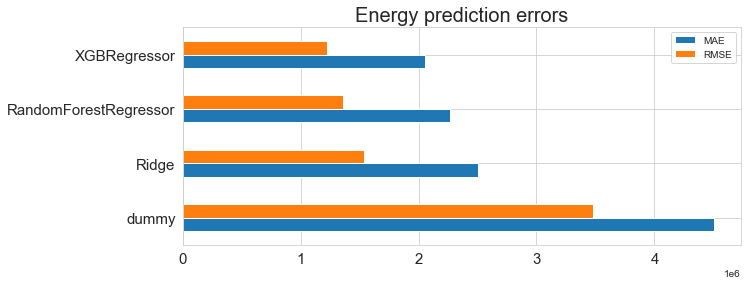

In [119]:
df_results_engy.plot.barh(y = ['MAE', 'RMSE'], x = 'model', figsize = (10,4), fontsize = 15)
plt.title('Energy prediction errors', fontsize = 20)
plt.ylabel('')
plt.savefig('erreurs-reelles-predites_engy', dpi = 200, bbox_inches ='tight')     


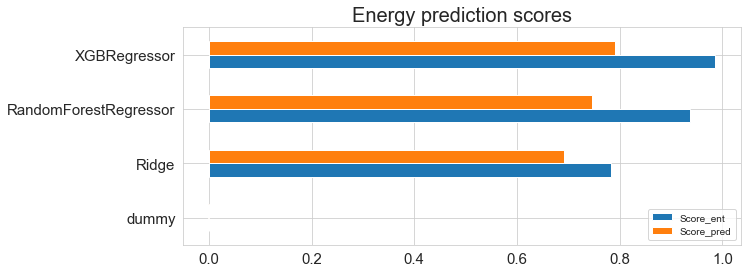

In [120]:
df_results_engy.plot.barh(figsize = (10,4), y = ['Score_ent', 'Score_pred'], x = 'model', fontsize = 15)
plt.title('Energy prediction scores', fontsize = 20)
plt.ylabel('')
plt.savefig('scores-reelles-predites_engy', dpi = 200, bbox_inches = 'tight')     



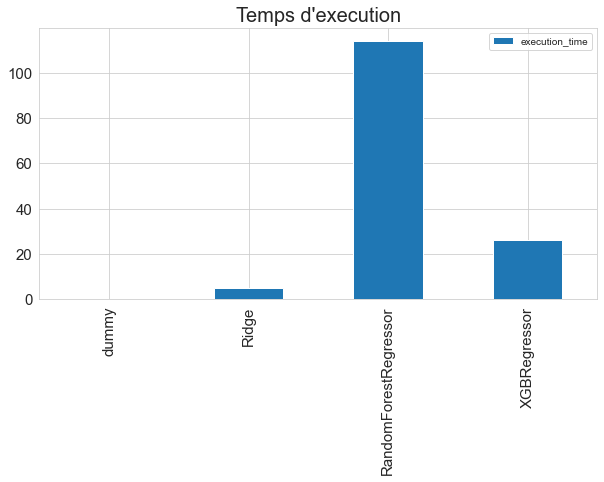

In [121]:
df_results_engy.plot(figsize = (10,5), kind = 'bar', y = ['execution_time'], x = 'model', fontsize = 15)
plt.title("Temps d'execution", fontsize = 20)
plt.xlabel('')
plt.savefig('execution time_engy', dpi = 200, bbox_inches = 'tight')    



### Pour la prédiction des gaz a effet de serre

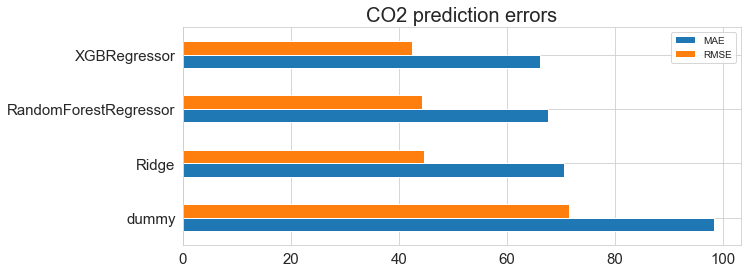

In [122]:
df_results_CO2.plot.barh(y = ['MAE', 'RMSE'], x = 'model', figsize = (10,4), fontsize = 15)
plt.title('CO2 prediction errors', fontsize = 20)
plt.ylabel('')
plt.savefig('errors-reelles-predites_gaz', dpi = 200, bbox_inches = 'tight') 


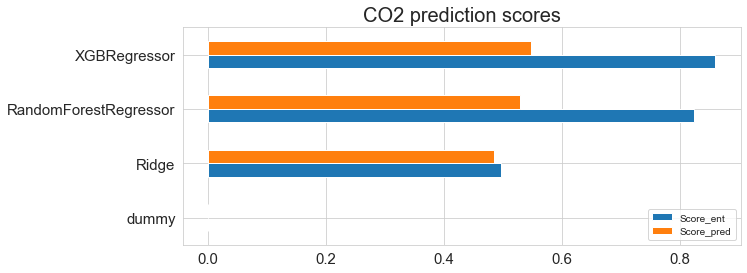

In [123]:
df_results_CO2.plot.barh(y = ['Score_ent','Score_pred'], x = 'model', figsize = (10,4), fontsize = 15)
plt.title('CO2 prediction scores', fontsize = 20)
plt.ylabel('')
plt.savefig('scores-reelles-predites_gaz', dpi = 200, bbox_inches = 'tight')


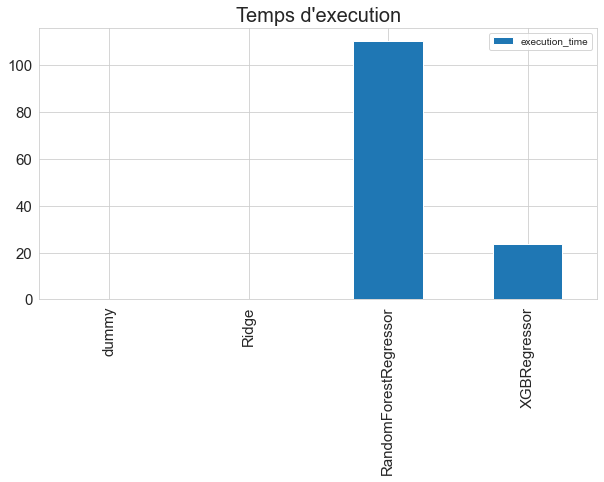

In [124]:
df_results_CO2.plot(figsize = (10,5), kind = 'bar', y = ['execution_time'], x = 'model', fontsize = 15)
plt.title("Temps d'execution", fontsize = 20)
plt.xlabel('')
plt.savefig('execution time_CO2', dpi = 200, bbox_inches = 'tight') 


Le modèle XGBRegressor donne les meilleurs résultats pour la prédiction de la consommation totale d'énergie ainsi que pour l'émission des gaz. Peut-on encore optimiser ce modèle pour chaque prédiction?

## Modèle final retenu XGBRegressor

### Optimiser chaque prédiction a part : la consommation d'énergie et l'émission de gaz 

In [125]:
# Energy use hyperparametre

# hyperparamètre pour energie a part 

df_ypred_engy = pd.DataFrame(columns = ['SiteEnergyUse(kBtu)'])

engy_escore = []

# Call the model 
xgb = XGBRegressor(random_state = 0)

mod = 'XGBRegressor'
engy = 'Escore'

xgb_grid = {'learning_rate': [0.05, 0.07, 0.08],
             'max_depth': [4, 5, 6, 7],
             'n_estimators':[100, 200, 300]
             }

model = GridSearchCV(estimator = xgb, param_grid = xgb_grid, cv = 5,
               scoring = 'r2', refit = 'r2',
               n_jobs = -1)

start_time = time.time()

y_train = y_train_all['SiteEnergyUse(kBtu)'] 
y_test = y_test_all['SiteEnergyUse(kBtu)'] 


model.fit(X_train_r, y_train) 


y_pred = model.predict(X_test_r)
    
score_entrainement = model.score(X_train_r, y_train)
score_prédiction =  model.score(X_test_r, y_test)
    
RMSE = mean_absolute_error(y_test, y_pred)
MAE = np.sqrt(mean_squared_error(y_test, y_pred))
MAPE = mean_absolute_percentage_error(y_test, y_pred)
R2 =  r2_score(y_test, y_pred)
    
print("")
print(f'Méthode: {mod} OneHotEncoder RobustScaler SiteEnergyUse(kBtu)')
print('-------------------------------------------------------------------------')
print("best params: ", model.best_params_)
print ("best score : ", model.best_score_)
    
print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
print("score_entrainement ", score_entrainement ) 
print("score_prédiction", score_prédiction)
    
print("RMSE = ", RMSE)
print("MAE = ", MAE)
print("MAPE = ", MAPE)
print("R2=", R2)
print('-------------------------------------------------------------------------')
    

engy_escore.append([mod, engy, score_entrainement, score_prédiction, MAE, MAPE, RMSE,  R2, (time.time() - start_time)])    
df_ypred_engy = y_pred
best_model_engy_es = clone(model.best_estimator_)


Méthode: XGBRegressor OneHotEncoder RobustScaler SiteEnergyUse(kBtu)
-------------------------------------------------------------------------
best params:  {'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 200}
best score :  0.7983719843019463
Temps d'execution de l'agorithme : 3.1e+01 s.
score_entrainement  0.9861627227808365
score_prédiction 0.791210718637375
RMSE =  1226055.5520566106
MAE =  2056676.489230211
MAPE =  47.56762040045286
R2= 0.791210718637375
-------------------------------------------------------------------------


In [126]:
# hyperparametre pour gaz


df_ypred_gaz = pd.DataFrame(columns=['TotalGHGEmissions'])
gaz_escore = [] 
# Call the model 
xgb = XGBRegressor(random_state=0)
mod = 'XGBRegressor'
gaz = 'Escore'
xgb_grid = {'learning_rate': [ 0.07,0.08, 0.09],
            'max_depth': [ 5, 6, 7],
             'n_estimators':[100,200]
            }

model = GridSearchCV(estimator = xgb, param_grid = xgb_grid, cv = 5,
               scoring = 'r2', refit = 'r2',
               n_jobs = -1)

start_time = time.time()
y_train = y_train_all['TotalGHGEmissions'] 
y_test = y_test_all['TotalGHGEmissions'] 


model.fit(X_train_r, y_train) 


y_pred = model.predict(X_test_r)
    
score_entrainement = model.score(X_train_r,y_train)
score_prédiction =  model.score(X_test_r, y_test)
    
RMSE = mean_absolute_error(y_test,y_pred)
MAE = np.sqrt(mean_squared_error(y_test,y_pred))
R2 =  r2_score(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)

print("")
print(f'Méthode: {mod} OneHotEncoder RobustScaler TotalGHGEmissions')
print('-------------------------------------------------------------------------')
print("best params: ", model.best_params_)
print ("best score : ", model.best_score_)
    
print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
print("score_entrainement ", score_entrainement ) 
print("score_prédiction", score_prédiction)
    
print("RMSE = ", RMSE)
print("MAE = ", MAE)
print("MAPE = ", MAPE)
print("R2=", R2)
print('-------------------------------------------------------------------------')
    

gaz_escore.append([mod, gaz, score_entrainement, score_prédiction, MAE, MAPE, RMSE,  R2, (time.time() - start_time)])       
df_ypred_gaz = y_pred
best_model_gaz_es = clone(model.best_estimator_)


Méthode: XGBRegressor OneHotEncoder RobustScaler TotalGHGEmissions
-------------------------------------------------------------------------
best params:  {'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100}
best score :  0.4778163023718827
Temps d'execution de l'agorithme : 1.3e+01 s.
score_entrainement  0.8883009270119502
score_prédiction 0.5501731154595505
RMSE =  42.05316742929129
MAE =  65.93036896269328
MAPE =  185.08493287458435
R2= 0.5501731154595505
-------------------------------------------------------------------------


###  Influence du nombre d'arbres sur la RMSE

In [127]:
# On récupère le meilleur modèlepour la prédiction de l'énergie
best_model = clone(best_model_engy_es)

# Calcul de la RMSE en fonction du nombre d'arbres
range_n_estimators = [x*x for x in range(1, 20)]
errors = []
time_fit, time_predict = [], []

for n_estimators in range_n_estimators :

    best_model.set_params(n_estimators = n_estimators)
    start_time_fit = time.time()
    best_model.fit(X_train_r, y_train_all["SiteEnergyUse(kBtu)"])
    time_fit.append(time.time() - start_time_fit)

    start_time_predict = time.time()
    y_pred = best_model.predict(X_test_r)
    
    time_predict.append(time.time() - start_time_predict)

    errors.append(np.sqrt(mean_squared_error(y_test_all["SiteEnergyUse(kBtu)"], y_pred))) 
    

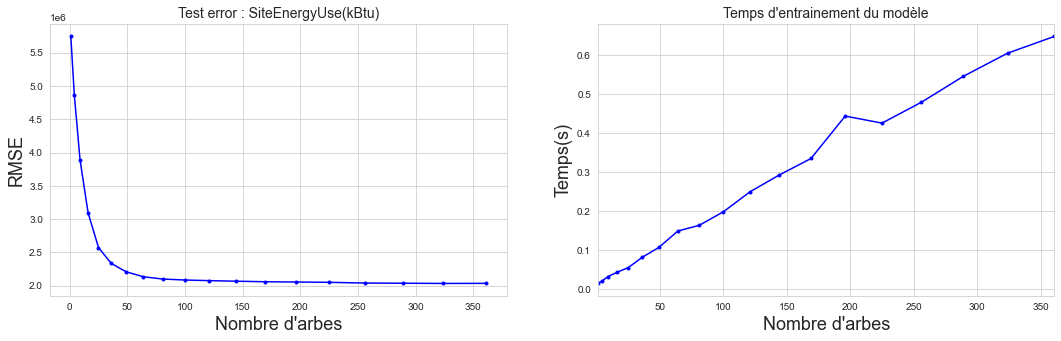

In [128]:
fig = plt.figure(1, figsize = (18, 5))

plt.subplot(121)
plt.plot(range_n_estimators, errors, "b.-")
plt.xlabel("Nombre d'arbes", fontsize = 18)
plt.ylabel('RMSE', fontsize = 18)

plt.title("Test error : SiteEnergyUse(kBtu)", fontsize = 14)

plt.subplot(122)
plt.plot(range_n_estimators, time_fit, "b.-")
plt.xlabel("Nombre d'arbes", fontsize = 18)
plt.ylabel('Temps(s)' , fontsize = 18)
plt.xlim(range_n_estimators[0], range_n_estimators[-1])
plt.title("Temps d'entrainement du modèle", fontsize = 14)

plt.savefig('erreurs-reelles-predites_engy_es_nb arbres', dpi = 200, bbox_inches = 'tight')     
plt.show()


### Saturation a partir de nombre d'arbres 200 ou on ne peut plus optimiser avec le nombre d'arbre

###  Influence du max_depth sur la RMSE

In [129]:
# max depth

# On récupère le meilleur modèle pour la prédiction de l'énergie
best_model = clone(best_model_gaz_es)

# Calcul de la RMSE en fonction du nombre d'arbres
range_max_depth = range(1, 15, 2)
errors = []
time_fit = []

for max_depth in range_max_depth :

    best_model.set_params(max_depth = max_depth)
    start_time_fit = time.time()
    best_model.fit(X_train_r, y_train_all["SiteEnergyUse(kBtu)"])
    time_fit.append(time.time() - start_time_fit)

    y_pred = best_model.predict(X_test_r)
    
    errors.append(np.sqrt(mean_squared_error(y_test_all["SiteEnergyUse(kBtu)"], y_pred)))
    

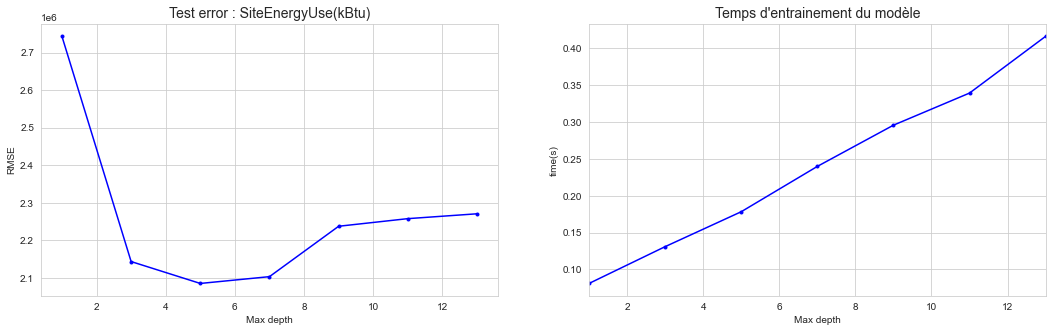

In [130]:
# max depth

fig = plt.figure(1, figsize = (18, 5))

plt.subplot(121)
plt.plot(range_max_depth, errors, "b.-")
plt.xlabel("Max depth")
plt.ylabel('RMSE')
plt.title("Test error : SiteEnergyUse(kBtu)", fontsize = 14)

plt.subplot(122)
plt.plot(range_max_depth, time_fit, "b.-")
plt.xlabel("Max depth")
plt.ylabel('time(s)')
plt.xlim(range_max_depth[0], range_max_depth[-1])
plt.title("Temps d'entrainement du modèle", fontsize = 14)

plt.savefig('erreurs-reelles-predites_engy_es_max depth', dpi = 200, bbox_inches = 'tight')     
plt.show()


### Minimum RMSE atteint pour max_depth = 5. Ajouter cette valeur a la GridSearch

## Influence de l'augmentation de la taille du jeu d'entrainement sur RMSE

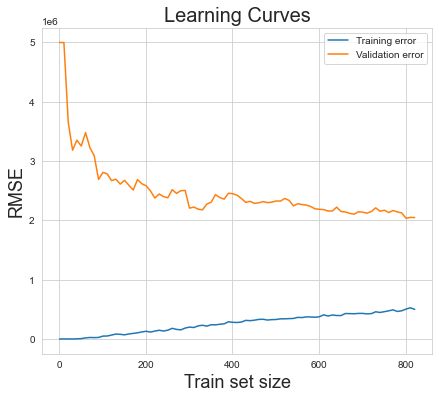

In [132]:
# On récupère le meilleur modèle pour la prédiction de l'énergie

plt.figure(figsize = (7,6))
training_size_rmse = plot_learning_curves(best_model_engy_es,
                                          X_train_r,
                                          X_test_r,
                                          y_train_all['SiteEnergyUse(kBtu)'],
                                          y_test_all['SiteEnergyUse(kBtu)'])

plt.savefig('rmse taille dataset', dpi = 200, bbox_inches = 'tight') 


Il faut plus de données pour que le modèle converge. L'ajout de données peut améliorer la preformance du modèle

En générale, le taux d'erreur sur les données d'apprentissage (train) commence bas lorsque la taille de dataset est petit et augmente au fur et à mesure que la taille augmente (car un ensemble d'apprentissage plus grand est plus difficile). D'autre part, le taux d'erreur sur les données de validation est généralement élevé pour un modèle formé sur peu de données et diminue quand le nombre des données augmente (car le modèle a appris pendant l'entrainement et est plus susceptible d'être valide pour des nouvelles données).


### Résultats des prédictions du modèle finale XGBRegressor

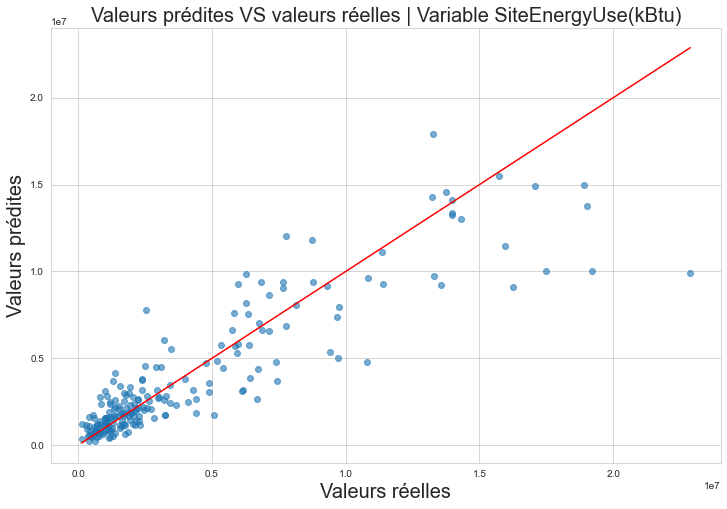

In [133]:
plot_pred_true(y_test_all["SiteEnergyUse(kBtu)"], df_ypred_engy, color = None, title = 'SiteEnergyUse(kBtu)')

plt.savefig('xgb-reelles-predites_engy', dpi = 200, bbox_inches = 'tight')  


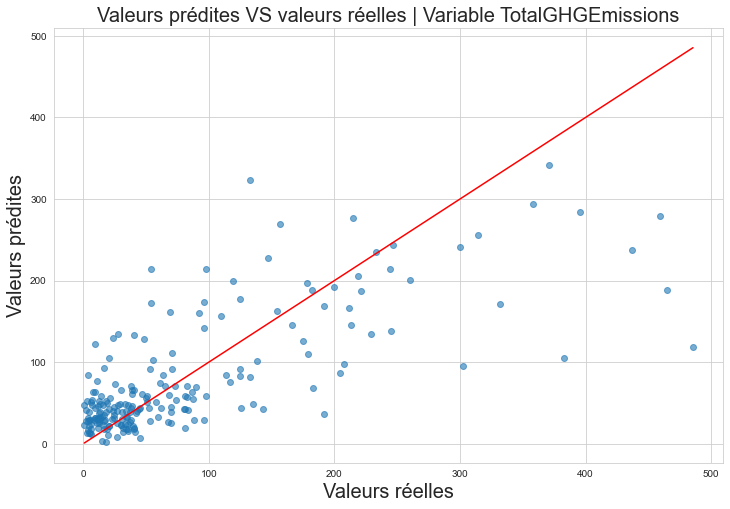

In [134]:
plot_pred_true(y_test_all['TotalGHGEmissions'] , df_ypred_gaz, color = None, title = 'TotalGHGEmissions')
plt.savefig('xgb-reelles-predites_gaz', dpi = 200, bbox_inches = 'tight')    

* On n'a pas assez des données pour les bâtiments à haute consommation d'énergie, ce qui explique les mauvaises prédictions à haute consommation d'énergie. Idem pour les prédictions d'émission des gaz


# Impact de EnergyStarScore 

## Feature importance

<Figure size 1440x1440 with 0 Axes>

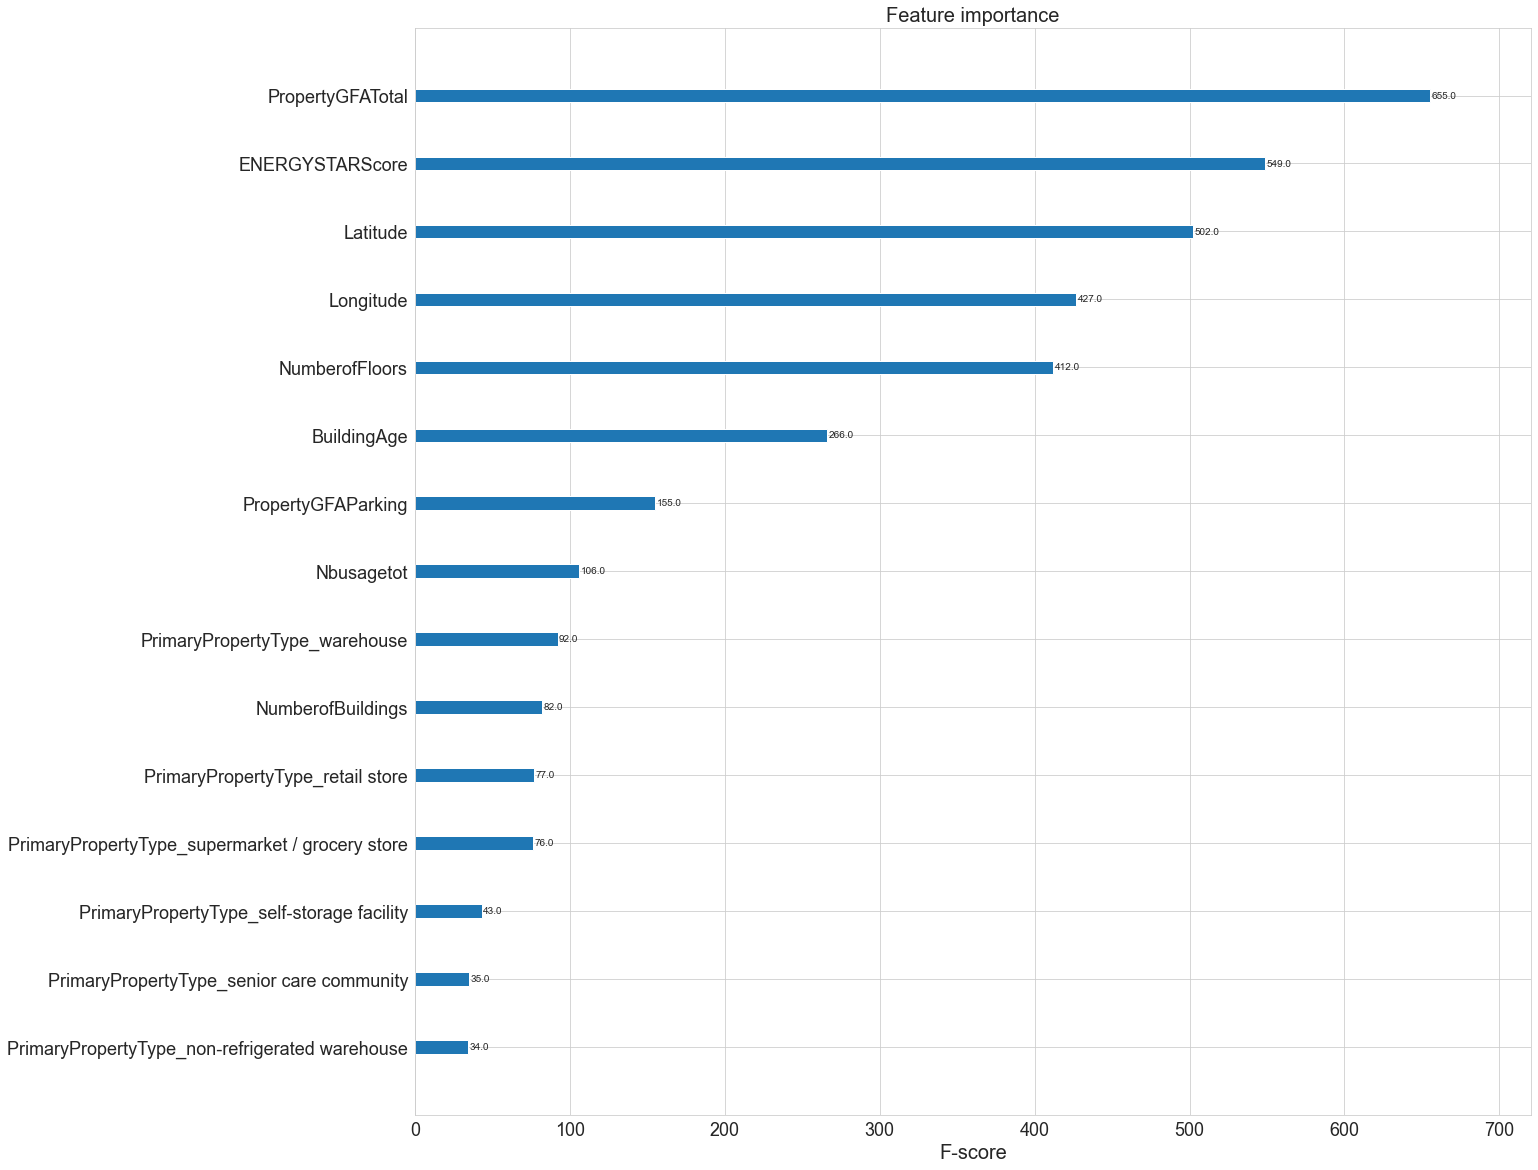

In [135]:
# Feature importance

plt.figure(figsize=(20,20))

plt.rcParams["figure.figsize"] = (20,20) 
xgboost.plot_importance(best_model_engy_es, max_num_features = 15)
plt.ylabel('')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('F-score', fontsize = 20)
plt.title('Feature importance', fontsize = 20)
plt.savefig('xgb-feature importance_top 15 engy Escore', dpi = 200, bbox_inches = 'tight') 


## Dans la prédiction de l'énergie consommée, EnergyStarScore est le 2ème attribut le plus important après propertyGFATotal qui est la surface totale de la propriété. 

In [137]:
# Feature importance  

plt.figure(figsize = (20,20))

plt.rcParams["figure.figsize"] = (20,20) 
xgboost.plot_importance(best_model_gaz_es, max_num_feature s = 15)
plt.ylabel('')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('F-score', fontsize = 20)
plt.title('Feature importance', fontsize = 20)
plt.savefig('xgb-feature importance_top 15 gaz ES', dpi = 200, bbox_inches = 'tight')   


Idem pour la prédiction d'émission de gaz. EnergyStarScore est le 2ème attribut le plus important

### Si on supprime ce paramètre fastidieux a calculer, comment cela affecte les résultats de prédictions de près?

In [138]:
X_train_r_wo_es = X_train_r.drop('ENERGYSTARScore', axis = 1)
X_test_r_wo_es = X_test_r.drop('ENERGYSTARScore', axis = 1)



In [139]:
# hyperparamètre pour énergie sans EnergyStarscore

df_ypred_wo_es_engy = pd.DataFrame(columns = ['SiteEnergyUse(kBtu)'])
# Call the model 
xgb = XGBRegressor(random_state = 0)
mod = 'XGBRegressor'
engy = 'no Escore'
xgb_grid = {'learning_rate': [0.04, 0.07, 0.08],
             'max_depth': [ 5, 6, 7],
             'n_estimators':[100, 200, 300]
            }

model = GridSearchCV(estimator = xgb, param_grid = xgb_grid, cv = 5,
               scoring = 'r2', refit = 'r2',
               n_jobs = -1)

start_time = time.time()
y_train = y_train_all['SiteEnergyUse(kBtu)'] 
y_test = y_test_all['SiteEnergyUse(kBtu)'] 


model.fit(X_train_r_wo_es, y_train) 


y_pred = model.predict(X_test_r_wo_es)
    
score_entrainement = model.score(X_train_r_wo_es, y_train)
score_prédiction =  model.score(X_test_r_wo_es, y_test)
    
RMSE = mean_absolute_error(y_test, y_pred)
MAE = np.sqrt(mean_squared_error(y_test, y_pred))
MAPE = mean_absolute_percentage_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
    
print("")
print(f'Méthode: {mod} OneHotEncoder RobustScaler SiteEnergyUse(kBtu)')
print('-------------------------------------------------------------------------')
print("best params: ", model.best_params_)
print ("best score : ", model.best_score_)
    
print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
print("score_entrainement ", score_entrainement ) 
print("score_prédiction", score_prédiction)
    
print("RMSE = ", RMSE)
print("MAE = ", MAE)
print("MAPE = ", MAPE)
print("R2=", R2)
print('-------------------------------------------------------------------------')
    

engy_escore.append([mod, engy, score_entrainement, score_prédiction, MAE, MAPE, RMSE,  R2, (time.time() - start_time)])      
df_ypred_wo_es_engy = y_pred
best_model_engy_wo_es = clone(model.best_estimator_)


Méthode: XGBRegressor OneHotEncoder RobustScaler SiteEnergyUse(kBtu)
-------------------------------------------------------------------------
best params:  {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 200}
best score :  0.690780810294964
Temps d'execution de l'agorithme : 2e+01 s.
score_entrainement  0.942155526194806
score_prédiction 0.6642412676793215
RMSE =  1565977.6192889423
MAE =  2608107.8241443643
MAPE =  80.26615533204894
R2= 0.6642412676793215
-------------------------------------------------------------------------


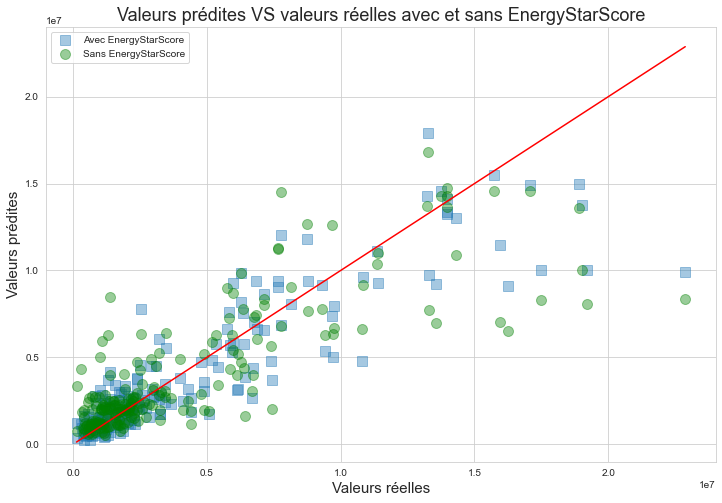

In [140]:
# Graphe avec et sans energystarscore: 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax1.scatter(y_test_all['SiteEnergyUse(kBtu)'], df_ypred_engy, s=100, c=None, marker="s",alpha=0.4, label='Avec EnergyStarScore')

ax1.scatter(y_test_all['SiteEnergyUse(kBtu)'],df_ypred_wo_es_engy, s=100, c='green', marker="o",alpha=0.4, label='Sans EnergyStarScore')
X_plot = [y_test_all['SiteEnergyUse(kBtu)'].min(), y_test_all['SiteEnergyUse(kBtu)'].max()]
ax1.plot(X_plot, X_plot, color='r')
plt.legend(loc='upper left');
plt.xlabel("Valeurs réelles",fontsize=15)
plt.ylabel("Valeurs prédites",fontsize=15)
plt.title("Valeurs prédites VS valeurs réelles avec et sans EnergyStarScore", 
              fontsize=18)
plt.savefig('xgb-reelles-predites_engy_avec et sans Escore', dpi=200, bbox_inches='tight')    
plt.show() 

Pas d'influence majeure de l'EnergyStarScore en première vue sur les prédictions. Qu'en est il des erreurs et des scores de prédictions?  

In [141]:
df_engy_escore = pd.DataFrame(engy_escore, columns=['model', 'EnergyScore', 'Score_ent', 'Score_pred', 'MAE', 'MAPE', 'RMSE', 'R2', 'execution_time'])
df_engy_escore

,model,EnergyScore,Score_ent,Score_pred,MAE,MAPE,RMSE,R2,execution_time
0,XGBRegressor,Escore,0.986163,0.791211,2.056676e+06,47.567620,1.226056e+06,0.791211,30.845749
1,XGBRegressor,no Escore,0.942156,0.664241,2.608108e+06,80.266155,1.565978e+06,0.664241,20.182562


In [142]:
df_engy_escore['perc-r2'] = df_engy_escore['R2']*100
df_engy_escore

,model,EnergyScore,Score_ent,Score_pred,MAE,MAPE,RMSE,R2,execution_time,perc-r2
0,XGBRegressor,Escore,0.986163,0.791211,2.056676e+06,47.567620,1.226056e+06,0.791211,30.845749,79.121072
1,XGBRegressor,no Escore,0.942156,0.664241,2.608108e+06,80.266155,1.565978e+06,0.664241,20.182562,66.424127


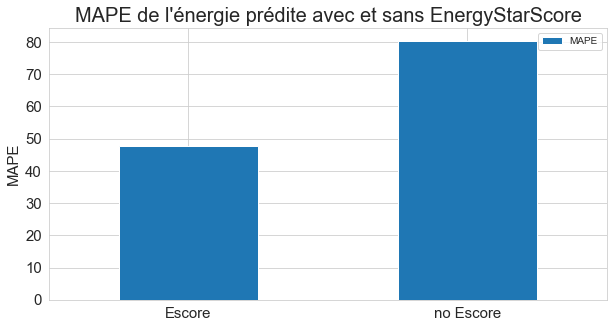

In [143]:

df_engy_escore.plot(figsize = (10,5), kind = 'bar', y = ['MAPE'], x = 'EnergyScore', fontsize = 15)
plt.title("MAPE de l'énergie prédite avec et sans EnergyStarScore", fontsize = 20)
plt.xticks(rotation = 'horizontal')
plt.xlabel('')
plt.ylabel('MAPE', fontsize = 15)
plt.savefig('MAPE engy avec et sans EnergyStarScore', dpi = 200, bbox_inches = 'tight') 


Le pourcentage d’erreur MAPE s’est beaucoup dégradé sans EnergyStarscore d’où son importance confirmé :
 
on passe d’une prédiction relativement acceptable pour l’énergie (MAPE 47%) à une prédiction très mauvaise (MAPE 80%)


In [144]:
# hyperparametre pour gaz without energy star

df_ypred_wo_es_gaz = pd.DataFrame(columns = ['TotalGHGEmissions'])

# Call the model 
xgb = XGBRegressor(random_state = 0)
mod = 'XGBRegressor'
gaz = 'no Escore'
xgb_grid= {'learning_rate': [ 0.07, 0.08, 0.09],
            'max_depth': [ 5, 6, 7],
             'n_estimators':[100, 200]
            }

model = GridSearchCV(estimator = xgb, param_grid = xgb_grid, cv = 5,
               scoring = 'r2', refit = 'r2',
               n_jobs = -1)

start_time = time.time()
y_train = y_train_all['TotalGHGEmissions'] 
y_test = y_test_all['TotalGHGEmissions'] 


model.fit(X_train_r_wo_es, y_train) 


y_pred = model.predict(X_test_r_wo_es)
    
score_entrainement = model.score(X_train_r_wo_es,y_train)
score_prédiction =  model.score(X_test_r_wo_es, y_test)
    
RMSE = mean_absolute_error(y_test, y_pred)
MAE = np.sqrt(mean_squared_error(y_test, y_pred))
MAPE = mean_absolute_percentage_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
    
print("")
print(f'Méthode: {mod} OneHotEncoder RobustScaler TotalGHGEmissions')
print('-------------------------------------------------------------------------')
print("best params: ", model.best_params_)
print ("best score : ", model.best_score_)
    
print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
print("score_entrainement ", score_entrainement ) 
print("score_prédiction", score_prédiction)
    
print("RMSE = ", RMSE)
print("MAE = ", MAE)
print("MAPE = ", MAPE)
print("R2=", R2)
print('-------------------------------------------------------------------------')
    

    
   
gaz_escore.append([mod, gaz, score_entrainement, score_prédiction, MAE, MAPE, RMSE,  R2, (time.time() - start_time)])       
df_ypred_wo_es_gaz = y_pred
best_model_gaz_wo_es = clone(model.best_estimator_)



Méthode: XGBRegressor OneHotEncoder RobustScaler TotalGHGEmissions
-------------------------------------------------------------------------
best params:  {'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100}
best score :  0.4212304922756383
Temps d'execution de l'agorithme : 1.2e+01 s.
score_entrainement  0.849083628185823
score_prédiction 0.4945920624271788
RMSE =  43.85473611923365
MAE =  69.88497776028804
MAPE =  225.14718071539676
R2= 0.4945920624271788
-------------------------------------------------------------------------


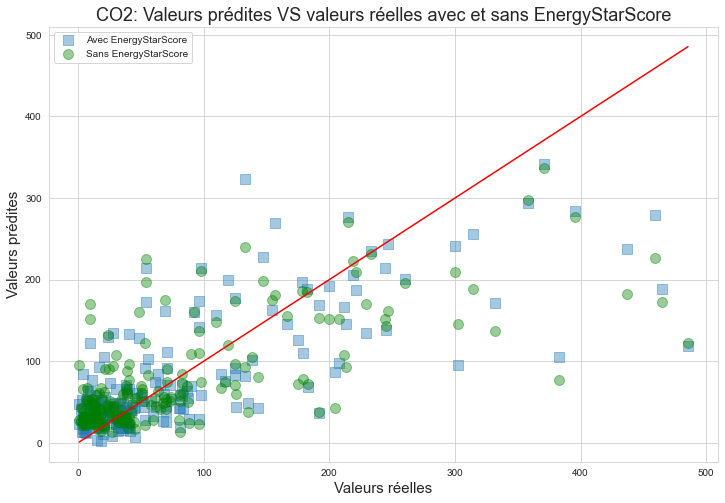

In [145]:
# Graphe prediction emission des gaz avec et sans energystarscore: 

fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(111)

ax1.scatter(y_test_all['TotalGHGEmissions'], df_ypred_gaz, s = 100, c = None, marker = "s",alpha = 0.4, label = 'Avec EnergyStarScore')

ax1.scatter(y_test_all['TotalGHGEmissions'], df_ypred_wo_es_gaz, s = 100, c = 'green', marker = "o", alpha = 0.4, label ='Sans EnergyStarScore')
X_plot = [y_test_all['TotalGHGEmissions'].min(), y_test_all['TotalGHGEmissions'].max()]
ax1.plot(X_plot, X_plot, color='r')
plt.legend(loc='upper left');
plt.xlabel("Valeurs réelles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.title("CO2: Valeurs prédites VS valeurs réelles avec et sans EnergyStarScore", 
              fontsize = 18)
plt.savefig('xgb-reelles-predites_gaz_avec et sans Escore', dpi = 200, bbox_inches = 'tight')    
plt.show() 

In [146]:
df_gaz_escore = pd.DataFrame(gaz_escore, columns = ['model', 'EnergyScore','Score_ent', 'Score_pred', 'MAE', 'MAPE', 'RMSE', 'R2', 'execution_time'])
df_gaz_escore

,model,EnergyScore,Score_ent,Score_pred,MAE,MAPE,RMSE,R2,execution_time
0,XGBRegressor,Escore,0.888301,0.550173,65.930369,185.084933,42.053167,0.550173,12.717724
1,XGBRegressor,no Escore,0.849084,0.494592,69.884978,225.147181,43.854736,0.494592,12.001591


In [147]:
df_gaz_escore['perc-r2'] = df_gaz_escore['R2']*100
df_gaz_escore

,model,EnergyScore,Score_ent,Score_pred,MAE,MAPE,RMSE,R2,execution_time,perc-r2
0,XGBRegressor,Escore,0.888301,0.550173,65.930369,185.084933,42.053167,0.550173,12.717724,55.017312
1,XGBRegressor,no Escore,0.849084,0.494592,69.884978,225.147181,43.854736,0.494592,12.001591,49.459206


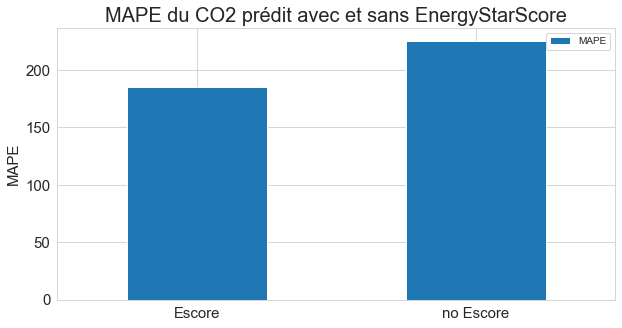

In [148]:
df_gaz_escore.plot(figsize = (10,5), kind = 'bar', y = ['MAPE'], x = 'EnergyScore',  fontsize = 15)
plt.title("MAPE du CO2 prédit avec et sans EnergyStarScore", fontsize = 20)
plt.xticks(rotation = 'horizontal')
plt.xlabel('')
plt.ylabel('MAPE', fontsize = 15)
plt.savefig('MAPE du CO2 prédit avec et sans EnergyStarScore', dpi = 200, bbox_inches = 'tight') 


In [ ]:
# On récupère le meilleur modèle déterminé pour la prédiction de l'énergie


plt.figure(figsize = (7,6))
training_size_rmse = plot_learning_curves(best_model_engy_wo_es,
                                          X_train_r,
                                          X_test_r,
                                          y_train_all['SiteEnergyUse(kBtu)'] ,
                                          y_test_all['SiteEnergyUse(kBtu)'] )
                       

plt.savefig('rmse taille dataset data wo ES', dpi = 200, bbox_inches = 'tight') 


## La performance du modèle pourrait s'améliorer avec l'augmentation du dataset 
## Je vais recupérer les 1/3 des données supprimées lors de la suppression des valeurs manquantes de EnergyStarScore pour confirmer ou infirmer cette conclusion 

In [150]:
df_ml_more = pd.read_csv("df_exp.csv")  

In [151]:
df_ml_more.shape

(1519, 16)

In [152]:
df_ml_more.drop(['BuildingType', 'LargestPropertyUseType', 'ENERGYSTARScore'], axis = 1, inplace = True)

In [153]:
df_ml_more["CouncilDistrictCode"] = df_ml_more["CouncilDistrictCode"].apply(str)
num = list(df_ml_more.select_dtypes(include = ['int64','float64']).columns)
cat = list(df_ml_more.select_dtypes(exclude = ['int64','float64']).columns) 

print(f"num =", num)
print(f"cat =", cat)


num = ['NumberofBuildings', 'NumberofFloors', 'Latitude', 'Longitude', 'PropertyGFATotal', 'PropertyGFAParking', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'BuildingAge', 'Nbusagetot']
cat = ['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood']


In [154]:
num = ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'Latitude', 'Longitude', 'PropertyGFATotal', 'PropertyGFAParking', 'BuildingAge', 'Nbusagetot']
cat

['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood']

In [155]:

y = df_ml_more.copy()[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]
X = df_ml_more.copy().drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis = 1)

# diviser le dataset en partie entrainement et une partie test
X_train, X_test, y_train_all, y_test_all = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [156]:
# Encodage et standarisation

X_train_num = rbst_scale.fit_transform(X_train[num])
X_test_num = rbst_scale.transform(X_test[num])

# df apres standarisation
rbs_train_df =  pd.DataFrame(X_train_num, columns = num)
rbs_test_df =  pd.DataFrame(X_test_num, columns = num)

X_train_cat = ohe.fit_transform(X_train[cat])
X_test_cat = ohe.transform(X_test[cat])

# df des variables encodes

ohe_train_df = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names(cat))
ohe_test_df = pd.DataFrame(X_test_cat, columns=ohe.get_feature_names(cat))
ohe_train_df

X_train_more = pd.concat([rbs_train_df, ohe_train_df], axis = 1)
X_test_more = pd.concat([rbs_test_df, ohe_test_df], axis = 1)

In [157]:
# energy use hyperparametre

# hyperparametre pour energie a part 

df_ypred_engy_more_wo = pd.DataFrame(columns = ['SiteEnergyUse(kBtu)'])

# Call the model 
xgb = XGBRegressor(random_state = 0)
mod='XGBRegressor'
xgb_grid= {'learning_rate': [0.05, 0.07, 0.08],
             'max_depth': [ 5, 6, 7],
             'n_estimators':[100, 200, 300]
            }

model = GridSearchCV(estimator = xgb, param_grid = xgb_grid, cv = 5,
               scoring = 'r2', refit = 'r2',
               n_jobs = -1)

start_time = time.time()
y_train = y_train_all['SiteEnergyUse(kBtu)'] 
y_test = y_test_all['SiteEnergyUse(kBtu)'] 


model.fit(X_train_more, y_train) 


y_pred = model.predict(X_test_more)
    
score_entrainement = model.score(X_train_more, y_train)
score_prédiction =  model.score(X_test_more, y_test)
    
RMSE = mean_absolute_error(y_test, y_pred)
MAE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
    
print("")
print(f'Méthode: {mod} OneHotEncoder RobustScaler SiteEnergyUse(kBtu)')
print('-------------------------------------------------------------------------')
print("best params: ", model.best_params_)
print ("best score : ", model.best_score_)
    
print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
print("score_entrainement ", score_entrainement ) 
print("score_prédiction", score_prédiction)
    
print("RMSE = ", RMSE)
print("MAE = ", MAE)
print("R2=", R2)
print('-------------------------------------------------------------------------')
    

    


df_ypred_engy_more_wo = y_pred
best_model_engy_more_wo_es = clone(model.best_estimator_)




Méthode: XGBRegressor OneHotEncoder RobustScaler SiteEnergyUse(kBtu)
-------------------------------------------------------------------------
best params:  {'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100}
best score :  0.6438994430331914
Temps d'execution de l'agorithme : 3.3e+01 s.
score_entrainement  0.8686092304964884
score_prédiction 0.7061453751684689
RMSE =  1555065.0696752958
MAE =  2553201.1673043463
R2= 0.7061453751684689
-------------------------------------------------------------------------


Avec plus de donnees, le score de prediction s'est ameliore (de 0.66 a 0.7) et les erreurs se sont ameliorees aussi mais pas beaucoup

<IPython.core.display.Javascript object>


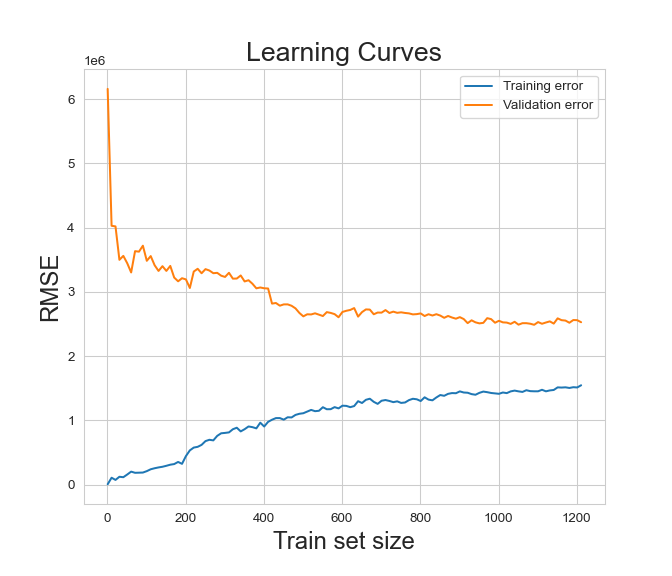

In [158]:
%matplotlib notebook
# On récupère le meilleur modèle déterminé pour la prédiction de l'énergie
reg = clone(model.best_estimator_)


plt.figure(figsize = (7,6))
training_size_rmse = plot_learning_curves(best_model_engy_more_wo_es,
                                          X_train_more,
                                          X_test_more,
                                          y_train,
                                          y_test)
                        

plt.savefig('rmse taille dataset more data wo ES', dpi = 200, bbox_inches = 'tight') 


 Les 2 scores convergent mieux avec plus de donnees

## Si j'ajoute plus d'attribut : ajouter la categorie LargestPropertyUseType

In [159]:
df_ml_more_feature = pd.read_csv("df_exp.csv")

In [160]:
df_ml_more_feature1 = df_ml_more_feature.copy()

In [161]:
df_ml_more_feature1.drop(['BuildingType', 'ENERGYSTARScore'], axis = 1, inplace = True)

In [162]:
df_ml_more_feature1["CouncilDistrictCode"] = df_ml_more_feature1["CouncilDistrictCode"].apply(str)
num = list(df_ml_more_feature1.select_dtypes(include = ['int64','float64']).columns)
cat = list(df_ml_more_feature1.select_dtypes(exclude = ['int64','float64']).columns) 

print(f"num =", num)
print(f"cat =", cat)


num = ['NumberofBuildings', 'NumberofFloors', 'Latitude', 'Longitude', 'PropertyGFATotal', 'PropertyGFAParking', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'BuildingAge', 'Nbusagetot']
cat = ['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType']


In [163]:
num = ['NumberofBuildings', 'NumberofFloors', 'Latitude', 'Longitude', 'PropertyGFATotal', 'PropertyGFAParking', 'BuildingAge', 'Nbusagetot']

In [164]:
y = df_ml_more_feature1.copy()[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]
X = df_ml_more_feature1.copy().drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis = 1)
# diviser le dataset en partie entraintement et une partie test
X_train, X_test, y_train_all, y_test_all = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [165]:
X_train_num = rbst_scale.fit_transform(X_train[num])
X_test_num = rbst_scale.transform(X_test[num])

# df apres standarisation
rbs_train_df = pd.DataFrame(X_train_num, columns = num)
rbs_test_df = pd.DataFrame(X_test_num, columns = num)

X_train_cat = ohe.fit_transform(X_train[cat])
X_test_cat = ohe.transform(X_test[cat])

# df des variables encodes

ohe_train_df = pd.DataFrame(X_train_cat, columns = ohe.get_feature_names(cat))
ohe_test_df = pd.DataFrame(X_test_cat, columns = ohe.get_feature_names(cat))
ohe_train_df

X_train_more_feature1 = pd.concat([rbs_train_df, ohe_train_df], axis = 1)
X_test_more_feature1 = pd.concat([rbs_test_df, ohe_test_df], axis = 1)


In [166]:
X_train_more_feature1.shape

(1215, 100)

In [167]:
# hyperparametre pour energie a part wo EScore plus une categorie

df_ypred_engy_more1_wo = ['SiteEnergyUse(kBtu)']
# Call the model 
xgb = XGBRegressor(random_state = 0)
mod='XGBRegressor'
xgb_grid= {'learning_rate': [0.04, 0.05, 0.07],
             'max_depth': [ 5, 7, 10],
             'n_estimators':[100, 200, 300]
           }

model = GridSearchCV(estimator = xgb, param_grid = xgb_grid, cv = 5,
               scoring = 'r2', refit = 'r2',
               n_jobs = -1)

start_time = time.time()
y_train = y_train_all['SiteEnergyUse(kBtu)'] 
y_test = y_test_all['SiteEnergyUse(kBtu)'] 


model.fit(X_train_more_feature1, y_train) 


y_pred = model.predict(X_test_more_feature1)
    
score_entrainement = model.score(X_train_more_feature1, y_train)
score_prédiction = model.score(X_test_more_feature1, y_test)
    
RMSE = mean_absolute_error(y_test, y_pred)
MAE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
    
print("")
print(f'Méthode: XGBRegressor OneHotEncoder RobustScaler SiteEnergyUse(kBtu)')
print('-------------------------------------------------------------------------')
print("best params: ", model.best_params_)
print ("best score : ", model.best_score_)
    
print("Temps d'execution de l'agorithme : {:.2} s.".format((time.time() - start_time))) 
print("score_entrainement ", score_entrainement ) 
print("score_prédiction", score_prédiction)
    
print("RMSE = ", RMSE)
print("MAE = ", MAE)
print("R2=", R2)
print('-------------------------------------------------------------------------')
    
#     results.append([mod, col, score_entrainement, score_prédiction, MAE, RMSE,  R2, (time.time() - start_time)])
    
df_ypred_engy_more1_wo = y_pred
best_model_engy_more__f_wo_es = clone(model.best_estimator_)



Méthode: XGBRegressor OneHotEncoder RobustScaler SiteEnergyUse(kBtu)
-------------------------------------------------------------------------
best params:  {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 200}
best score :  0.6442529759841007
Temps d'execution de l'agorithme : 6.4e+01 s.
score_entrainement  0.8746713451941225
score_prédiction 0.7161333786571344
RMSE =  1567720.72972875
MAE =  2509434.8993453523
R2= 0.7161333786571344
-------------------------------------------------------------------------


### Légère amélioration sur le score de prédiction mais pas sur les erreurs

<IPython.core.display.Javascript object>


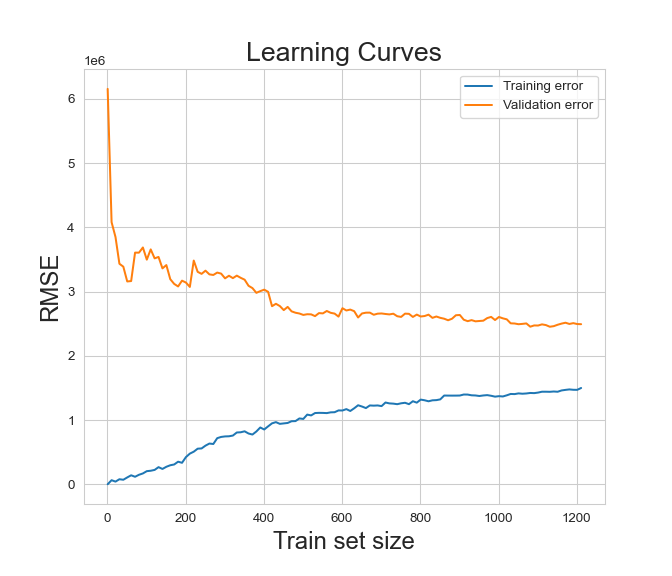

In [168]:
# Influence de l'ajout de feature sur RMSE en fonction de la taille de dataset

plt.figure(figsize = (7,6))
training_size_rmse = plot_learning_curves(best_model_engy_more__f_wo_es,
                                          X_train_more_feature1,
                                          X_test_more_feature1,
                                          y_train,
                                          y_test)

plt.savefig('rmse taille dataset more data wo ES more feature', dpi = 200, bbox_inches = 'tight') 


 Pas d'amélioration noté!  

# Conclusion

En conclusion, le modèle XGBoostRegressor a donné les meilleurs résultats avec les erreurs les plus faibles et les scores de prédictions les plus élevés. La performance était moins bonne sur la prediction des émissions des gaz. Avec feature_importance on a demontré l'importance de ENERGYSTARScore dans la décision du modèle (2ème attribut le plus important). La suppression de ENERGYSTARScore du modèle a montré une dégradation des résultats.

